In [1]:
import numpy as np
from lab3_tools import *
from lab3_proto import *
from tqdm import tqdm
import os
import keras
from matplotlib.pyplot import plot as tplt
import warnings
warnings.filterwarnings('ignore')



%pylab inline
pylab.rcParams['figure.figsize'] = (15, 4)

## Import scripts from lab1
import sys
sys.path.insert(1, '../Lab1/')
from lab1_proto import*

## Import scripts from lab2
import sys
sys.path.insert(1, '../Lab2/')
from lab2_proto import*
from prondict import*

## Auto-reloading
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load parameters
phoneHMMs_all = np.load('../Lab2/lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
# phoneHMMs_one = load('../Lab2/lab2_models_onespkr.npz',allow_pickle=True)['phoneHMMs'].item()
print("phoneme HMM models:")
phones = sorted(phoneHMMs_all.keys())
print(list(phones))
print(phoneHMMs_all['sp'].keys())

# Pronaunciation dictionary
print()
print("============")
print("The pronancuation dictionary:")
prondict

phoneme HMM models:
['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']
dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])

The pronancuation dictionary:


{'o': ['ow'],
 'z': ['z', 'iy', 'r', 'ow'],
 '1': ['w', 'ah', 'n'],
 '2': ['t', 'uw'],
 '3': ['th', 'r', 'iy'],
 '4': ['f', 'ao', 'r'],
 '5': ['f', 'ay', 'v'],
 '6': ['s', 'ih', 'k', 's'],
 '7': ['s', 'eh', 'v', 'ah', 'n'],
 '8': ['ey', 't'],
 '9': ['n', 'ay', 'n']}

In [12]:
# Load example data
example = load('lab3_example.npz',allow_pickle=True)['example'].item()
example.keys()

dict_keys(['filename', 'samples', 'gender', 'speaker', 'digits', 'repetition', 'lmfcc', 'wordTrans', 'phoneTrans', 'utteranceHMM', 'stateTrans', 'obsloglik', 'viterbiLoglik', 'viterbiPath', 'viterbiStateTrans'])

In [10]:
import pickle

## Load models
phoneHMMs_all = np.load('../Lab2/lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs_all.keys())

# phone: nr of states
nstates = {phone: phoneHMMs_all[phone]['means'].shape[0] for phone in phones}
# list of all states(3 states for each phone)
stateList = [ph + '_' + str(id) for ph in phones for id in range(nstates[ph])]

# Saving the objects:
#pickle.dump([nstates, stateList, phones], open('saved_files/phoneHMM_states.pkl', 'wb'))

# Getting back the objects:
# nstates, stateList, phones = pickle.load( open('saved_files/phoneHMM_states.pkl', 'rb'))

In [15]:
# My functions deliver the same outputs as excpected from example
filename = '../datasets/tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
print(np.allclose(example['samples'], samples))
lmfcc = mfcc(samples)
print(np.allclose(example['lmfcc'], lmfcc)) #!!
wordTrans = list(path2info(filename)[2])
print(example['wordTrans'] == wordTrans)

True
True
True


###  List of concatenated phones for word

In [20]:
phoneTrans = words2phones(wordTrans, prondict)
print(example['phoneTrans']== phoneTrans)
stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
print(example['stateTrans'] == stateTrans)
print(phoneTrans)

True
True
['sil', 'z', 'iy', 'r', 'ow', 'sp', 'f', 'ao', 'r', 'sp', 'th', 'r', 'iy', 'sp', 'sil']


In [23]:
utteranceHMM = concatHMMs(phoneHMMs_all, phoneTrans)

# Check that means, covar and startprob of concatened HMM are the same as in example
for i in example['utteranceHMM'].keys():
    print(np.allclose(utteranceHMM[i], example['utteranceHMM'][i]))
    
print("Number of states for the concatenated HMM of the example (0f3):", utteranceHMM['means'].shape[0])


True
True
True
True
Number of states for the concatenated HMM of the example (0f3): 39


## Viterbi

Correct obsloglik: True
Correct viterbi: True


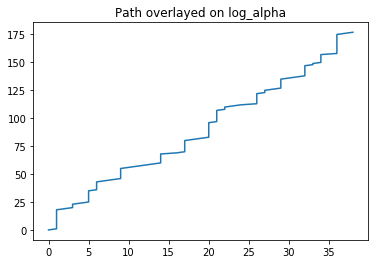

In [31]:
obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']), True)
plt.plot(viterbi_path, np.arange(len(viterbi_path)))
plt.title("Path overlayed on log_alpha")
print("Correct obsloglik:",np.allclose(obsloglik, example['obsloglik']))
print("Correct viterbi:",np.allclose(viterbi_path, example['viterbiPath']))

In [39]:
viterbiStateTrans = list(np.array(stateTrans)[viterbi_path,])
print("Correct viterbi path state trans:", viterbiStateTrans ==  example['viterbiStateTrans'])

print("\nPath of states:",viterbiStateTrans)
targets = [stateList.index(k) for k in list(np.array(stateTrans)[viterbi_path,])]
print("\nPath of targets(indexes):",targets)

Correct viterbi path state trans: True

Path of states: ['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'z_0', 'z_0', 'z_0', 'z_0', 'z_1', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', '

In [46]:
_=frames2trans(viterbiStateTrans,outfilename='z43a.lab')# save the path states in file format that can be used in wavesurfer

# Feature Extraction

### Extract training and test data

In [50]:
!python3  Lab3_load_training_and_test_set.py

Nr of words in training set: 8623
Nr of words in testing set: 8700
Nr of timesteps for train data: 1507057
Nr of timesteps for test data: 1526682


# 4) Concatinating HMMs

## Train-Valid Split

In [51]:
!python3 Lab3_split_train_valid.py

0.9000347906760988 0.0999652093239012
Trainign set: Women-> 3956 , Men-> 3805
Validation set: Women-> 432 , Men-> 430


## Create Dynamic Features

In [52]:
!python3 Lab3_create_dynamic_features.py

Training set has 1357194 lmfcc_x samples with dimension  91 .
Training set has 1357194 mspec_x samples with dimension  280 .
Test set has 1526682 lmfcc_x samples with dimension  91 .
Test set has 1526682 mspec_x samples with dimension  280 .
Validation set has 149863 lmfcc_x samples with dimension  91 .
Validation set has 149863 mspec_x samples with dimension  280 .


## Normalizing and one-hot encoding of targets

In [3]:
%python3 Lab3_normalize.py

datas/                              lab3_tools.py
Lab3_create_dynamic_features.py     __pycache__/
lab3_example.npz                    saved_files/
Lab3.ipynb                          testdata.npz
Lab3_load_training_and_test_set.py  traindata.npz
Lab3_normalize.py                   training_set.npz
lab3.pdf                            validation_set.npz
lab3_proto.py                       z43a.lab
Lab3_split_train_valid.py


# Phoneme Recognition with Deep Neural Networks

In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


nstates, stateList, phones = pickle.load( open('saved_files/phoneHMM_states.pkl', 'rb'))

## 1) Dynamic Lmfcc as features 

In [53]:
with np.load('datas/lmfcc_train_x_reg.npz', allow_pickle=True) as data:
    X = data['lmfcc_x']
    Y = data['targets']
with np.load('datas/lmfcc_test_x_reg.npz', allow_pickle=True) as data:
    X_test = data['lmfcc_x']
    Y_test = data['targets']

### Rmsprop

In [26]:
model = Sequential()
model.add(Dense(50, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(100, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X, Y, epochs=12, batch_size=256)
model.save("lmfcc_dyn_recognizer_rmsprop.h5")

Epoch 1/12
1357194/1357194 [==============================] - 16s 12us/step - loss: 1.0131 - accuracy: 0.6793
Epoch 2/12
1357194/1357194 [==============================] - 16s 12us/step - loss: 0.8022 - accuracy: 0.7387
Epoch 3/12
1357194/1357194 [==============================] - 18s 13us/step - loss: 0.7598 - accuracy: 0.7516
Epoch 4/12
1357194/1357194 [==============================] - 19s 14us/step - loss: 0.7394 - accuracy: 0.7576
Epoch 5/12
1357194/1357194 [==============================] - 17s 13us/step - loss: 0.7278 - accuracy: 0.7609
Epoch 6/12
1357194/1357194 [==============================] - 17s 13us/step - loss: 0.7203 - accuracy: 0.7632
Epoch 7/12
1357194/1357194 [==============================] - 17s 13us/step - loss: 0.7153 - accuracy: 0.7647
Epoch 8/12
1357194/1357194 [==============================] - 18s 13us/step - loss: 0.7116 - accuracy: 0.7661
Epoch 9/12
1357194/1357194 [==============================] - 18s 13us/step - loss: 0.7090 - accuracy: 0.7668
Epoch 10/1

1526682/1526682 [==============================] - 13s 8us/step
accuracy: 73.55%

Confusion Matrix


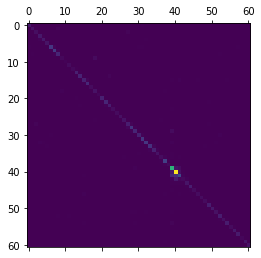

In [73]:
model = load_model("lmfcc_dyn_recognizer_rmsprop.h5")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Y_pred = model.predict(X_test)
print('\nConfusion Matrix')
plt.matshow(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))
plt.show()

# print('Classification Report')
# print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=stateList))

### Adam

In [40]:
model = Sequential()
model.add(Dense(50, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(100, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
opt = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X, Y, epochs=30, batch_size=256)
model.save("lmfcc_dyn_recognizer_adam.h5")

Epoch 1/30
1357194/1357194 [==============================] - 16s 12us/step - loss: 1.0430 - accuracy: 0.6715
Epoch 2/30
1357194/1357194 [==============================] - 15s 11us/step - loss: 0.8319 - accuracy: 0.7303
Epoch 3/30
1357194/1357194 [==============================] - 15s 11us/step - loss: 0.7848 - accuracy: 0.7442
Epoch 4/30
1357194/1357194 [==============================] - 15s 11us/step - loss: 0.7587 - accuracy: 0.7519
Epoch 5/30
1357194/1357194 [==============================] - 15s 11us/step - loss: 0.7409 - accuracy: 0.7575
Epoch 6/30
1357194/1357194 [==============================] - 17s 12us/step - loss: 0.7281 - accuracy: 0.7611
Epoch 7/30
1357194/1357194 [==============================] - 16s 12us/step - loss: 0.7181 - accuracy: 0.7642
Epoch 8/30
1357194/1357194 [==============================] - 16s 11us/step - loss: 0.7098 - accuracy: 0.7666
Epoch 9/30
1357194/1357194 [==============================] - 18s 13us/step - loss: 0.7026 - accuracy: 0.7688
Epoch 10/3

1526682/1526682 [==============================] - 12s 8us/step
accuracy: 75.00%

Confusion Matrix


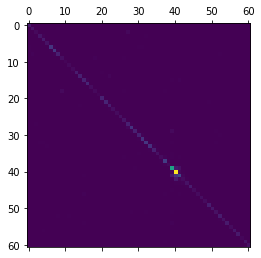

In [76]:
model = load_model("lmfcc_dyn_recognizer_adam.h5")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Y_pred = model.predict(X_test)
print('\nConfusion Matrix')
plt.matshow(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))
plt.show()
# print('Classification Report')
# print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=stateList))

## Dynamic Mspec as features

In [8]:
with np.load('datas/mspec_train_x_reg.npz', allow_pickle=True) as data:
    X = data['lmfcc_x']
    Y = data['targets']
    
    
X = None
Y = None
with np.load('datas/mspec_test_x_reg.npz', allow_pickle=True) as data:
    X_test = data['lmfcc_x']
    Y_test = data['targets']

In [7]:
model = Sequential()
model.add(Dense(50, input_shape=(X.shape[1],), activation='relu') )
model.add(Dense(100, activation='relu'))
model.add(Dense(Y.shape[1], activation='sigmoid'))
opt = keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X, Y, epochs=15, batch_size=256)
model.save("mspec_dyn_recognizer_adam.h5")

Epoch 1/15
1357194/1357194 [==============================] - 19s 14us/step - loss: 1.0752 - accuracy: 0.6596
Epoch 2/15
1357194/1357194 [==============================] - 19s 14us/step - loss: 0.8389 - accuracy: 0.7273
Epoch 3/15
1357194/1357194 [==============================] - 18s 13us/step - loss: 0.7875 - accuracy: 0.7428
Epoch 4/15
1357194/1357194 [==============================] - 18s 14us/step - loss: 0.7593 - accuracy: 0.7509
Epoch 5/15
1357194/1357194 [==============================] - 19s 14us/step - loss: 0.7411 - accuracy: 0.7558
Epoch 6/15
1357194/1357194 [==============================] - 18s 13us/step - loss: 0.7275 - accuracy: 0.7596
Epoch 7/15
1357194/1357194 [==============================] - 19s 14us/step - loss: 0.7175 - accuracy: 0.7630
Epoch 8/15
1357194/1357194 [==============================] - 26s 19us/step - loss: 0.7086 - accuracy: 0.7650
Epoch 9/15
1357194/1357194 [==============================] - 21s 16us/step - loss: 0.7018 - accuracy: 0.7674
Epoch 10/1

1526682/1526682 [==============================] - 14s 9us/step
accuracy: 74.26%

Confusion Matrix


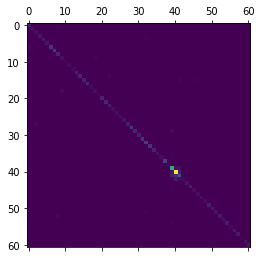

Classification Report
              precision    recall  f1-score   support

        ah_0       0.57      0.81      0.67     18732
        ah_1       0.68      0.66      0.67     15513
        ah_2       0.52      0.70      0.60     11269
        ao_0       0.79      0.75      0.77     14732
        ao_1       0.80      0.75      0.78     16593
        ao_2       0.77      0.83      0.80     12841
        ay_0       0.85      0.79      0.82     38703
        ay_1       0.84      0.85      0.84     37216
        ay_2       0.68      0.73      0.71     26225
        eh_0       0.50      0.58      0.53     11809
        eh_1       0.81      0.71      0.76      3333
        eh_2       0.72      0.79      0.76      7243
        ey_0       0.59      0.54      0.57      9276
        ey_1       0.79      0.84      0.82     19208
        ey_2       0.84      0.81      0.83     23634
         f_0       0.73      0.65      0.69     25993
         f_1       0.87      0.86      0.86     24580
     

In [10]:
model = load_model("mspec_dyn_recognizer_adam.h5")
score = model.evaluate(X_test, Y_test, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Y_pred = model.predict(X_test)
print('\nConfusion Matrix')
plt.matshow(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))
plt.show()
print('Classification Report')
print(classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=stateList))